# 프로젝트5 : 나의 첫 번째 캐글 경진대회, 무작정 따라해보기


---


#목차
집 값 예측하기

0. 들어가기 앞서
1. 데이터 준비    
  (1) data 살펴보기
2. 데이터 정제
3. 모델링



---

#0. 들어가기 앞서
코드가 굉장히 길어지는 이유로   
LMS 대로 진행한 부분은 따로 링크를 걸겠습니다.
초반에 Colab에서 콘다가 진행되지 않아 미니콘다 설치 및 다양한 방법으로 노력한 흔적을 볼 수 있습니다.

[👉🏻캐글 무작정 따라하기 앞부분](https://github.com/LAGABI44/aiffel_projects/blob/exploration/%5BE_05%5DKaggle_front.ipynb)


---
#1. 데이터 준비

##(1) data 살펴보기
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 가장 가까운 15개 집의 주거 공간의 평방 피트의 평균
21. sqft_lot15 : 가장 가까운 15개 집의 부지의 평방 피트의 평균2. 


##(2) 필요한 폴더 및 라이브러리 준비

In [ ]:
! mkdir -p /content/aiffel/kaggle_kakr_housing/data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# matplotlib 시각화
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

np.random.seed(111)

print('Ok, good!')

Ok, good!


##(3) 데이터 가져오기

In [ ]:
#data load
data_dir = '/content/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')        # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

#데이터 불러오기
#train = pd.read_csv(train_data_path)
#sub = pd.read_csv(sub_data_path)

#print('train data dim : {}'.format(train.shape))
#print('sub data dim : {}'.format(sub.shape))

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

/content/aiffel/kaggle_kakr_housing/data/train.csv
/content/aiffel/kaggle_kakr_housing/data/test.csv
train data dim : (15035, 21)
sub data dim : (6468, 20)


In [ ]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


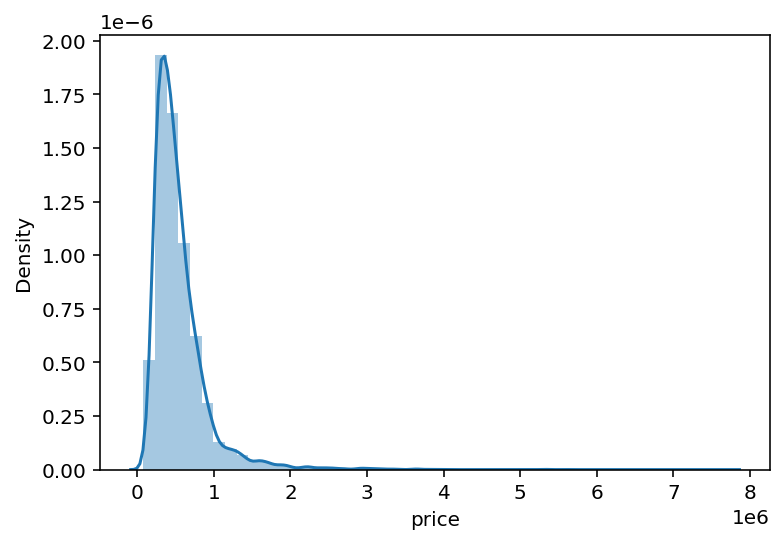

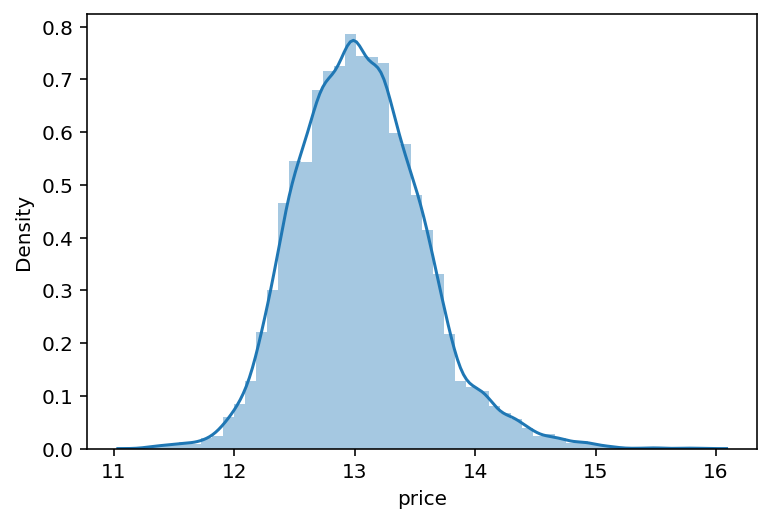

In [ ]:
sns.distplot(data['price'])
data['price'] = np.log1p(data['price'])

#histogram
f, ax = plt.subplots()
sns.distplot(data['price'])

In [ ]:
train_len = len(data)
plus = pd.concat((data, sub), axis=0)

print(len(data))

15035


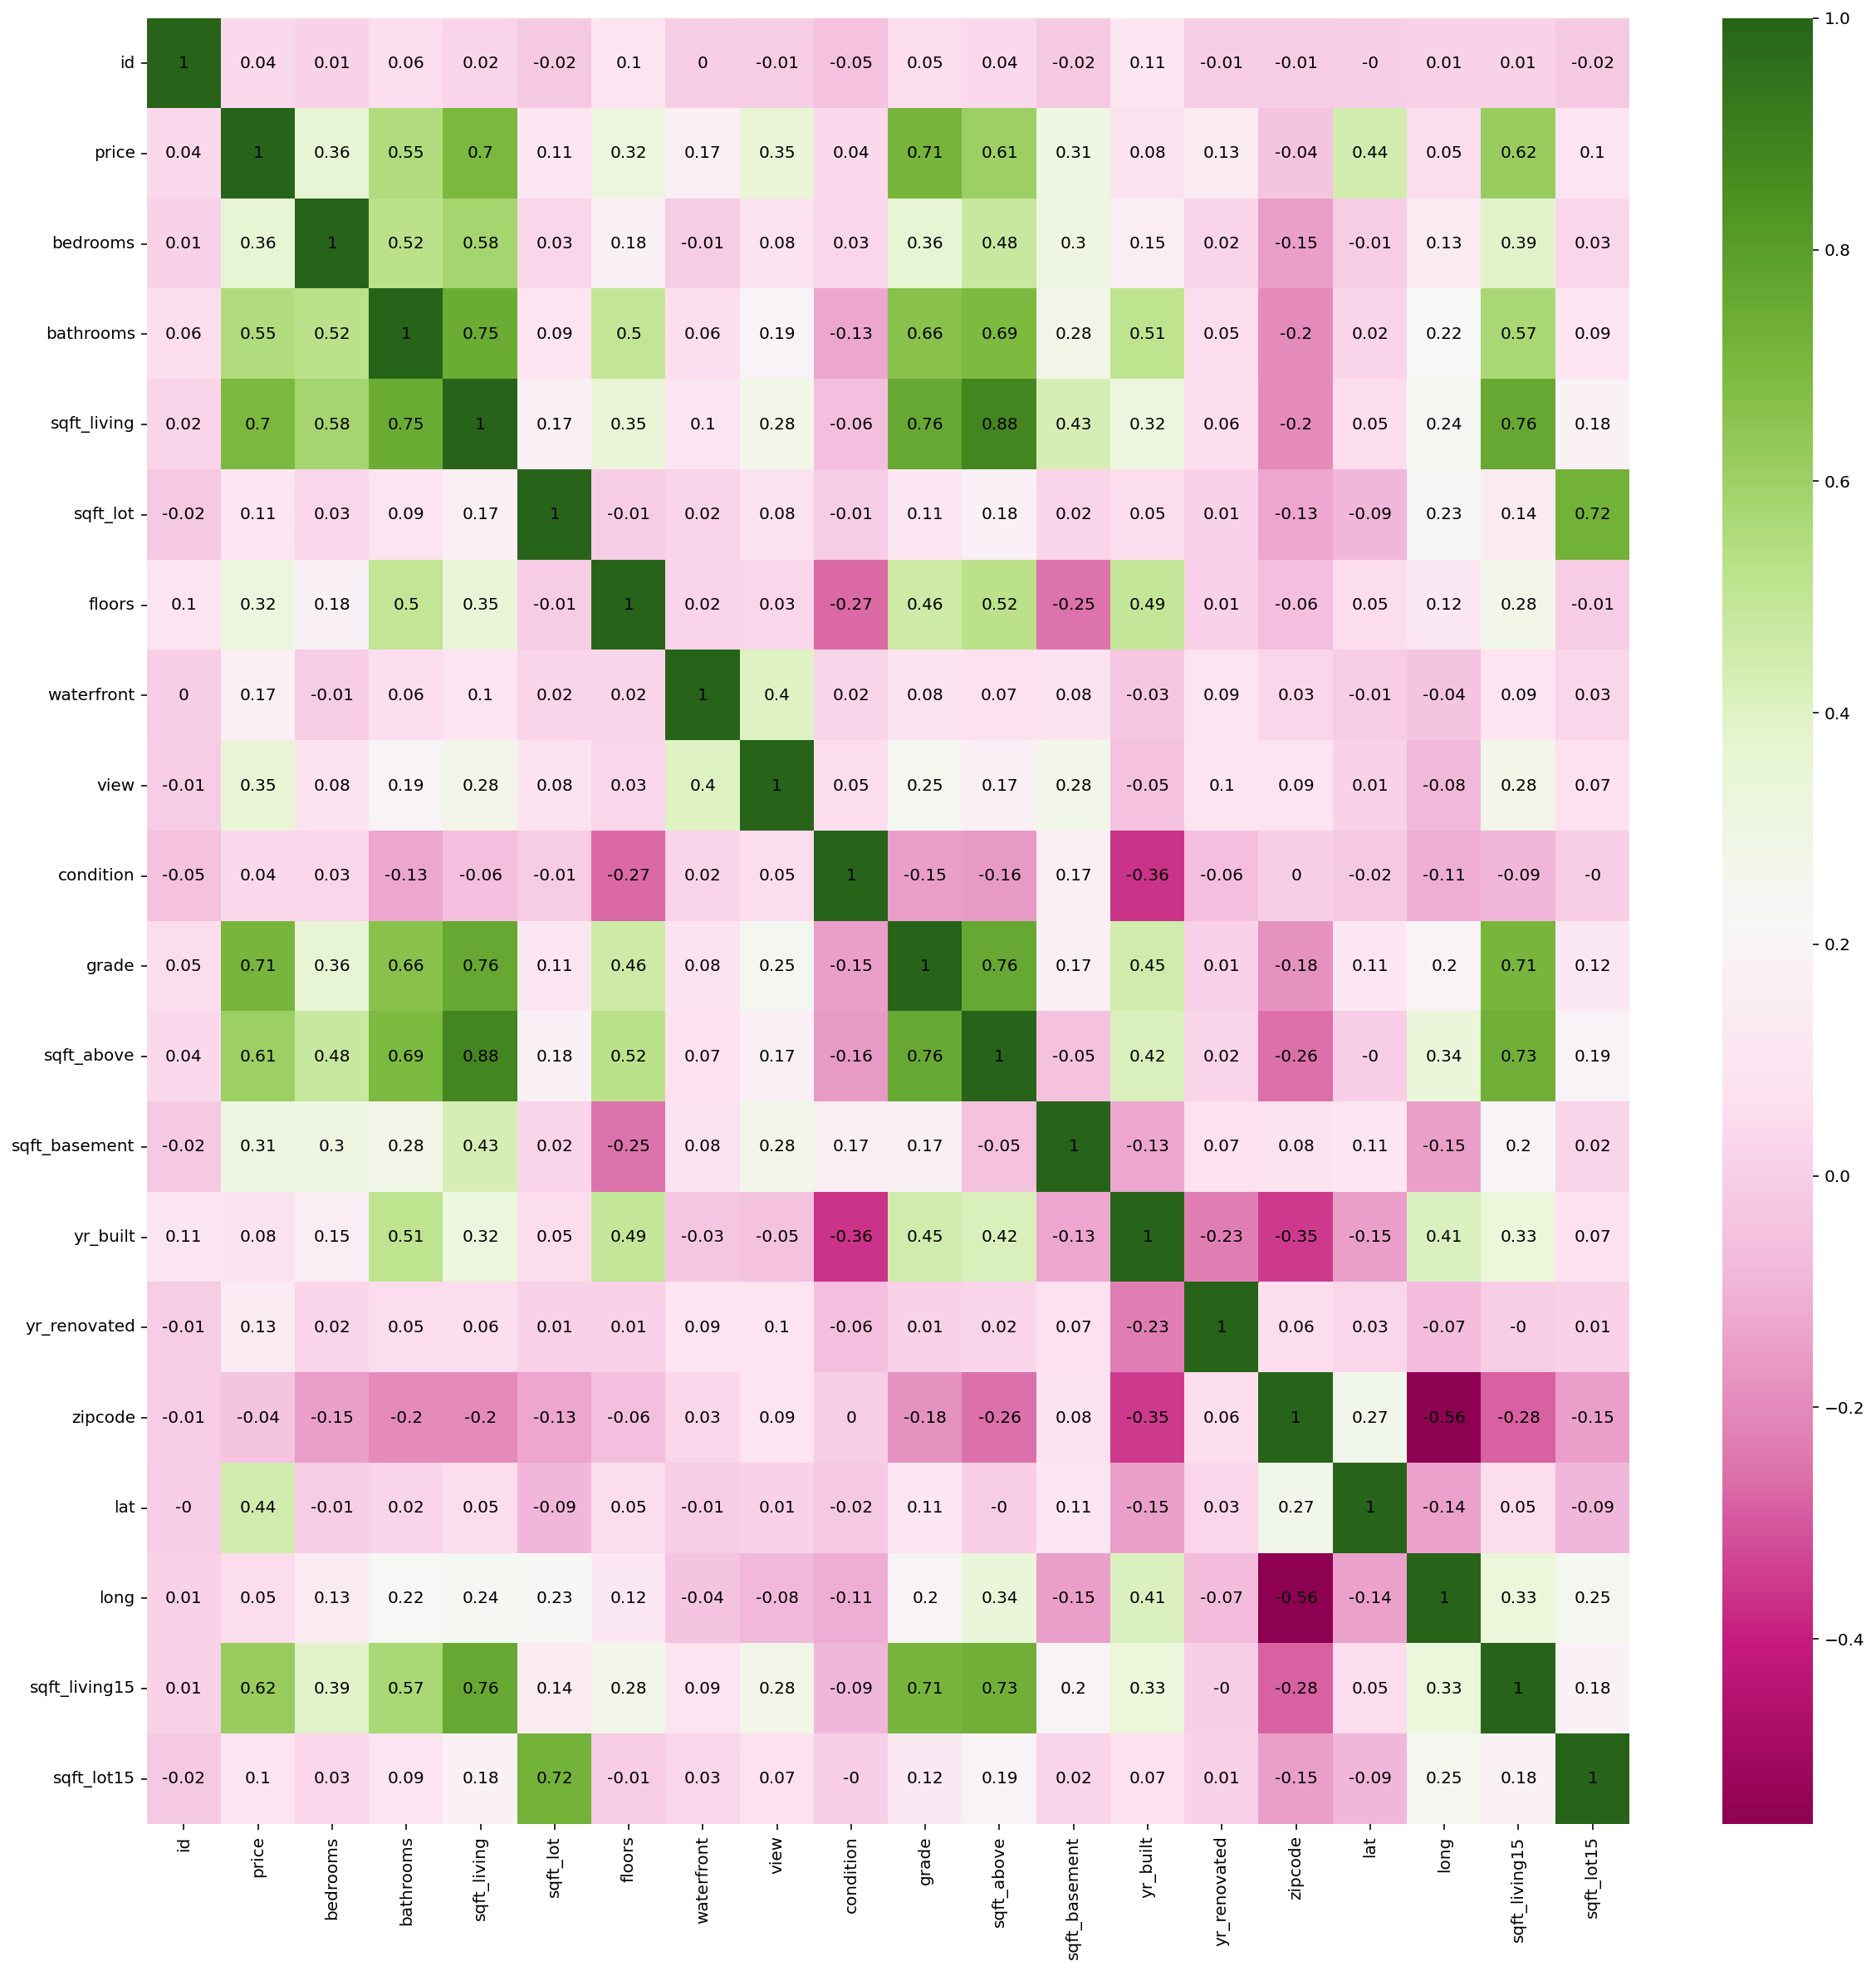

In [ ]:
corr_df = plus.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))

cor_abs = abs(plus.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)

plt.figure(figsize=(20,20))   #아 이부분이 아래로 내려가면 크기 변경에 영향을 못 주는구나..!
ax = sns.heatmap(corr_df, annot=True, annot_kws=dict(color='black'), cmap='PiYG')   #YlGnBu, RdBu 도 이쁨
plt.show()

In [ ]:
# price에 대한 다른 변수들의 상관관계
co = pd.DataFrame(corr_df["price"].sort_values(ascending = False))  #Price에 대한 다른 변수 수치 뽑기, 내림차순 정렬
co.style.background_gradient(cmap='viridis')    #스타일 지정해서 범위 별 색깔 입히기

,price
price,1.000000
grade,0.710000
sqft_living,0.700000
sqft_living15,0.620000
sqft_above,0.610000
bathrooms,0.550000
lat,0.440000
bedrooms,0.360000
view,0.350000
floors,0.320000


In [ ]:
#이상치 제거
plus = plus[plus['id'] != 8912]
plus = plus[plus['id'] != 201502]
plus = plus[plus['id'] != 201411]
plus = plus[plus['id'] != 201504]
plus = plus[plus['id'] != 983]

print("ok")

ok


In [ ]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
plus.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
plus['date'] = plus['date'].apply(lambda i: i[:8]).astype("int")

plus.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
data['date'] = data['date'].apply(lambda i: i[:8]).astype("int")
sub['date'] = sub['date'].apply(lambda i: i[:8]).astype("int")

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


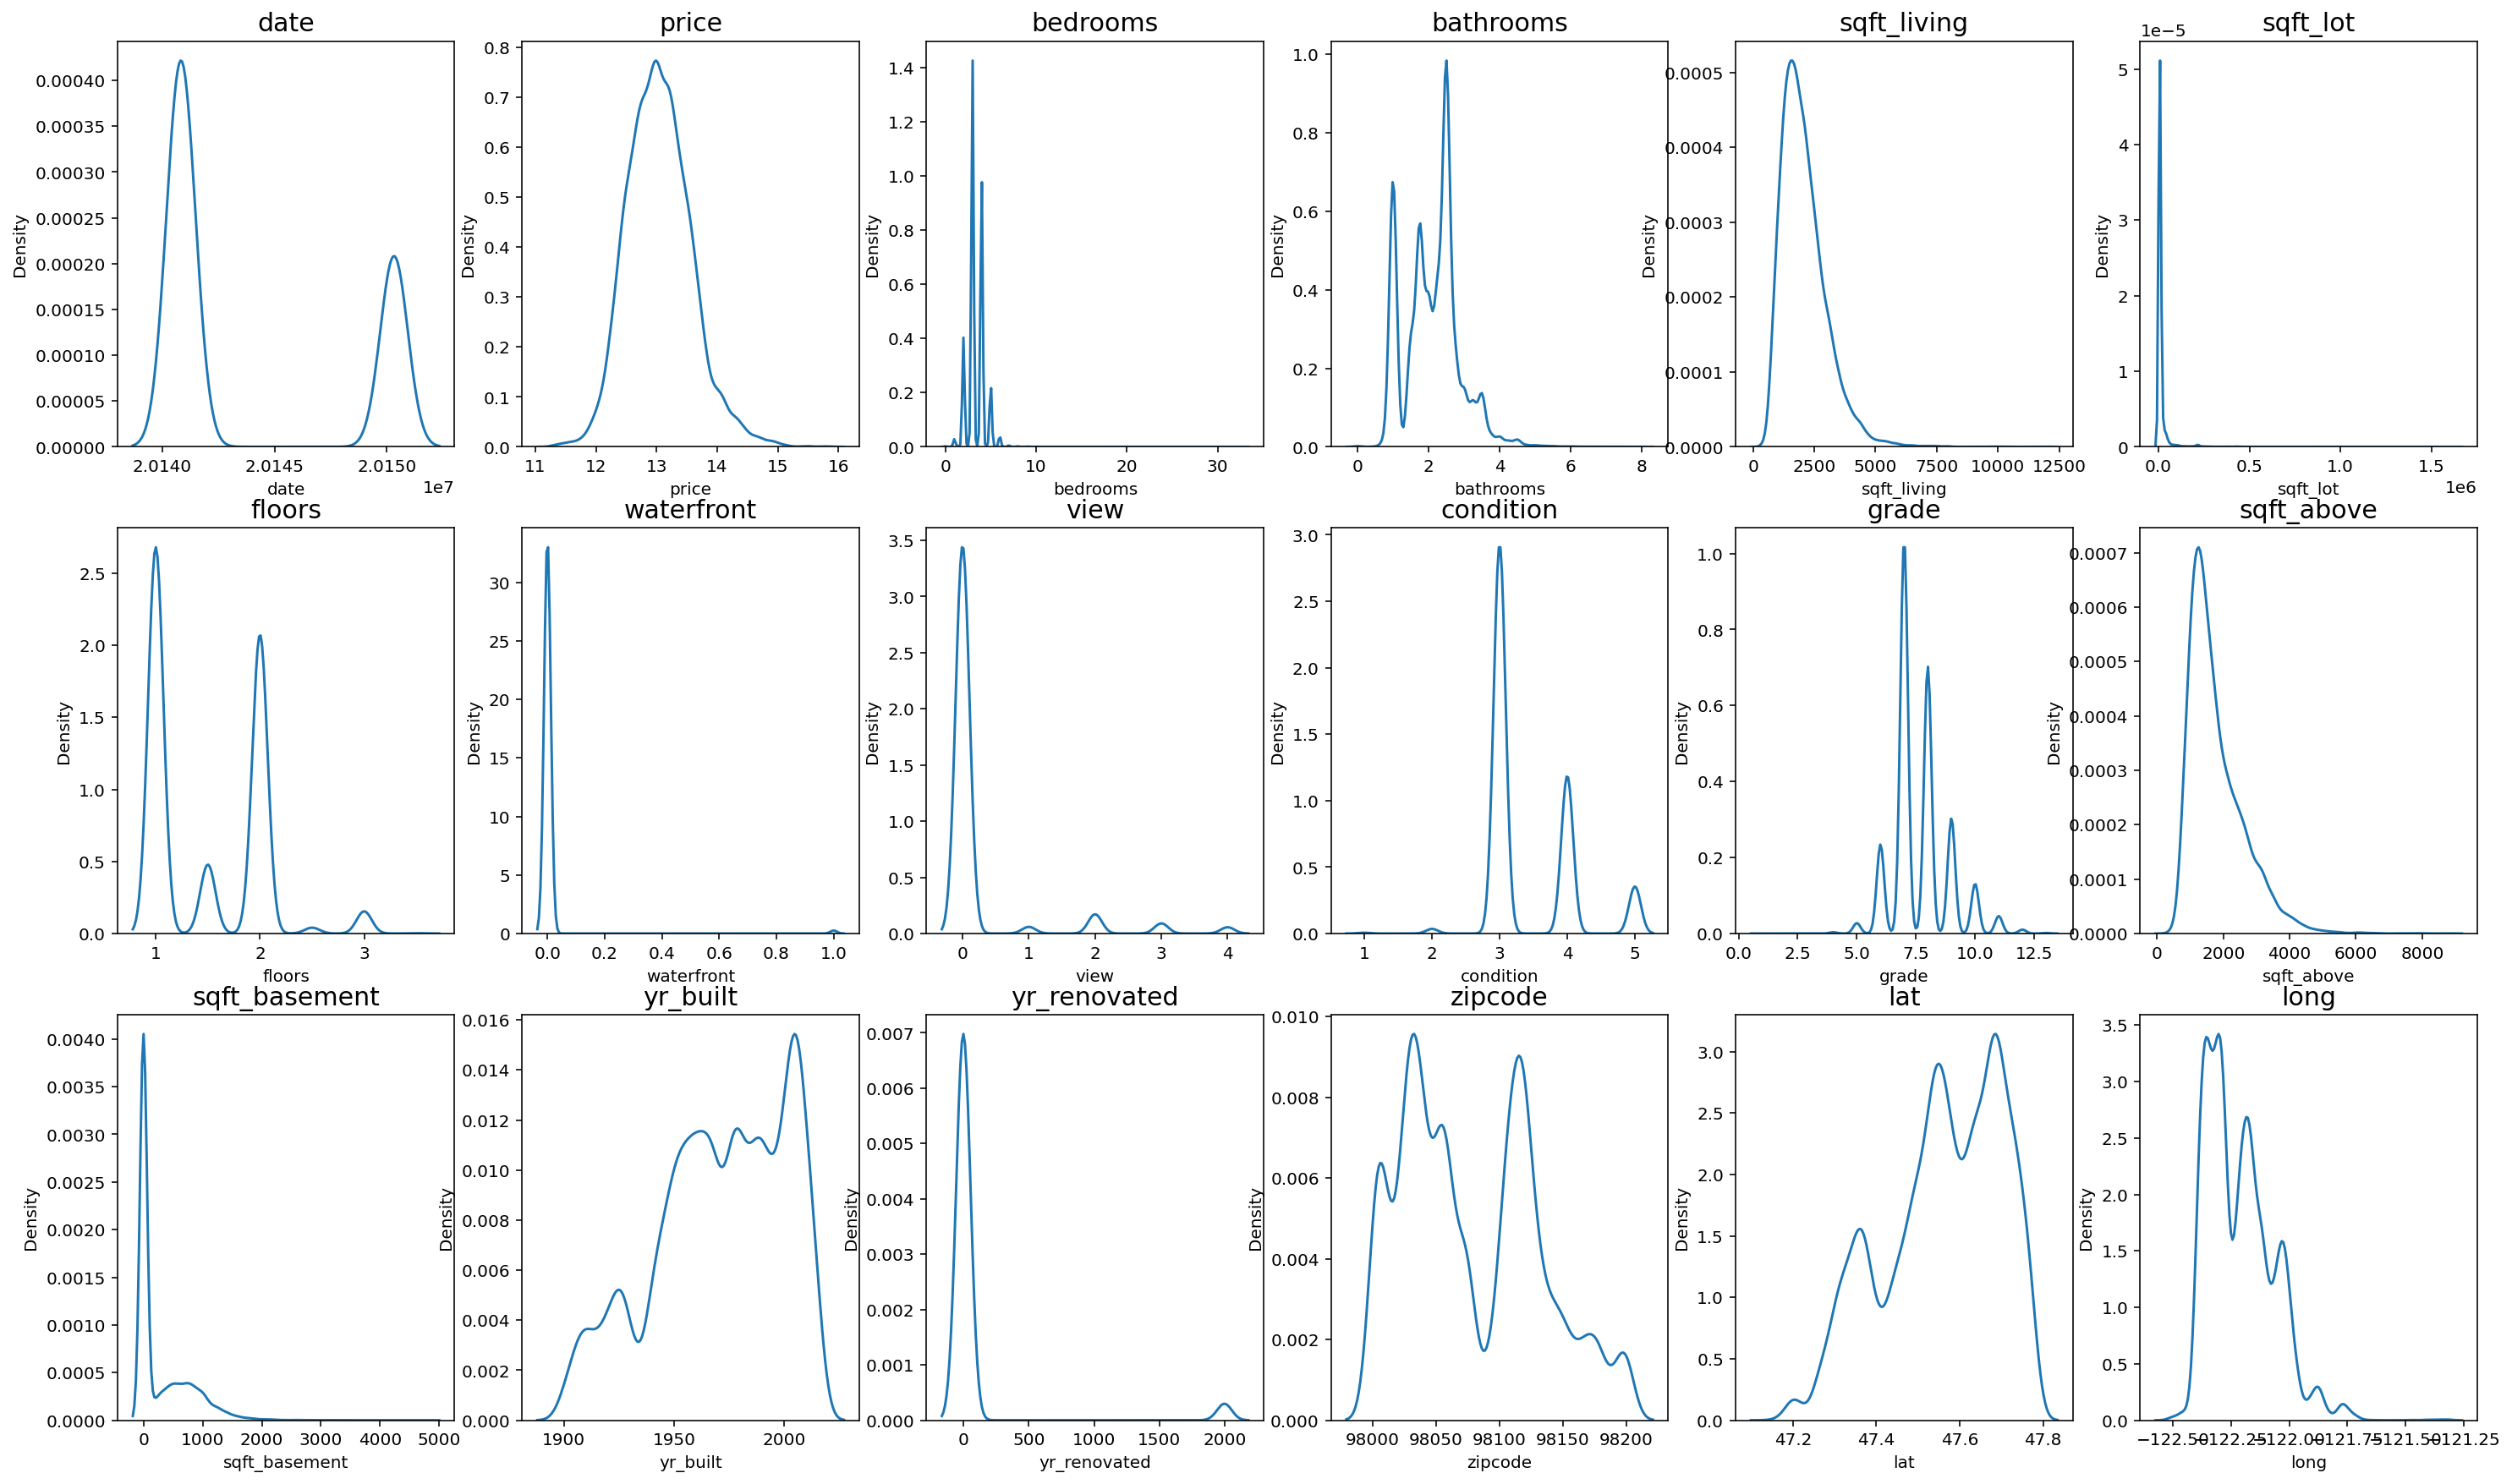

In [ ]:
fig, ax = plt.subplots(3, 6, figsize=(25, 15))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = plus.columns
for row in range(3):
    for col in range(6):
        sns.kdeplot(data=plus[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

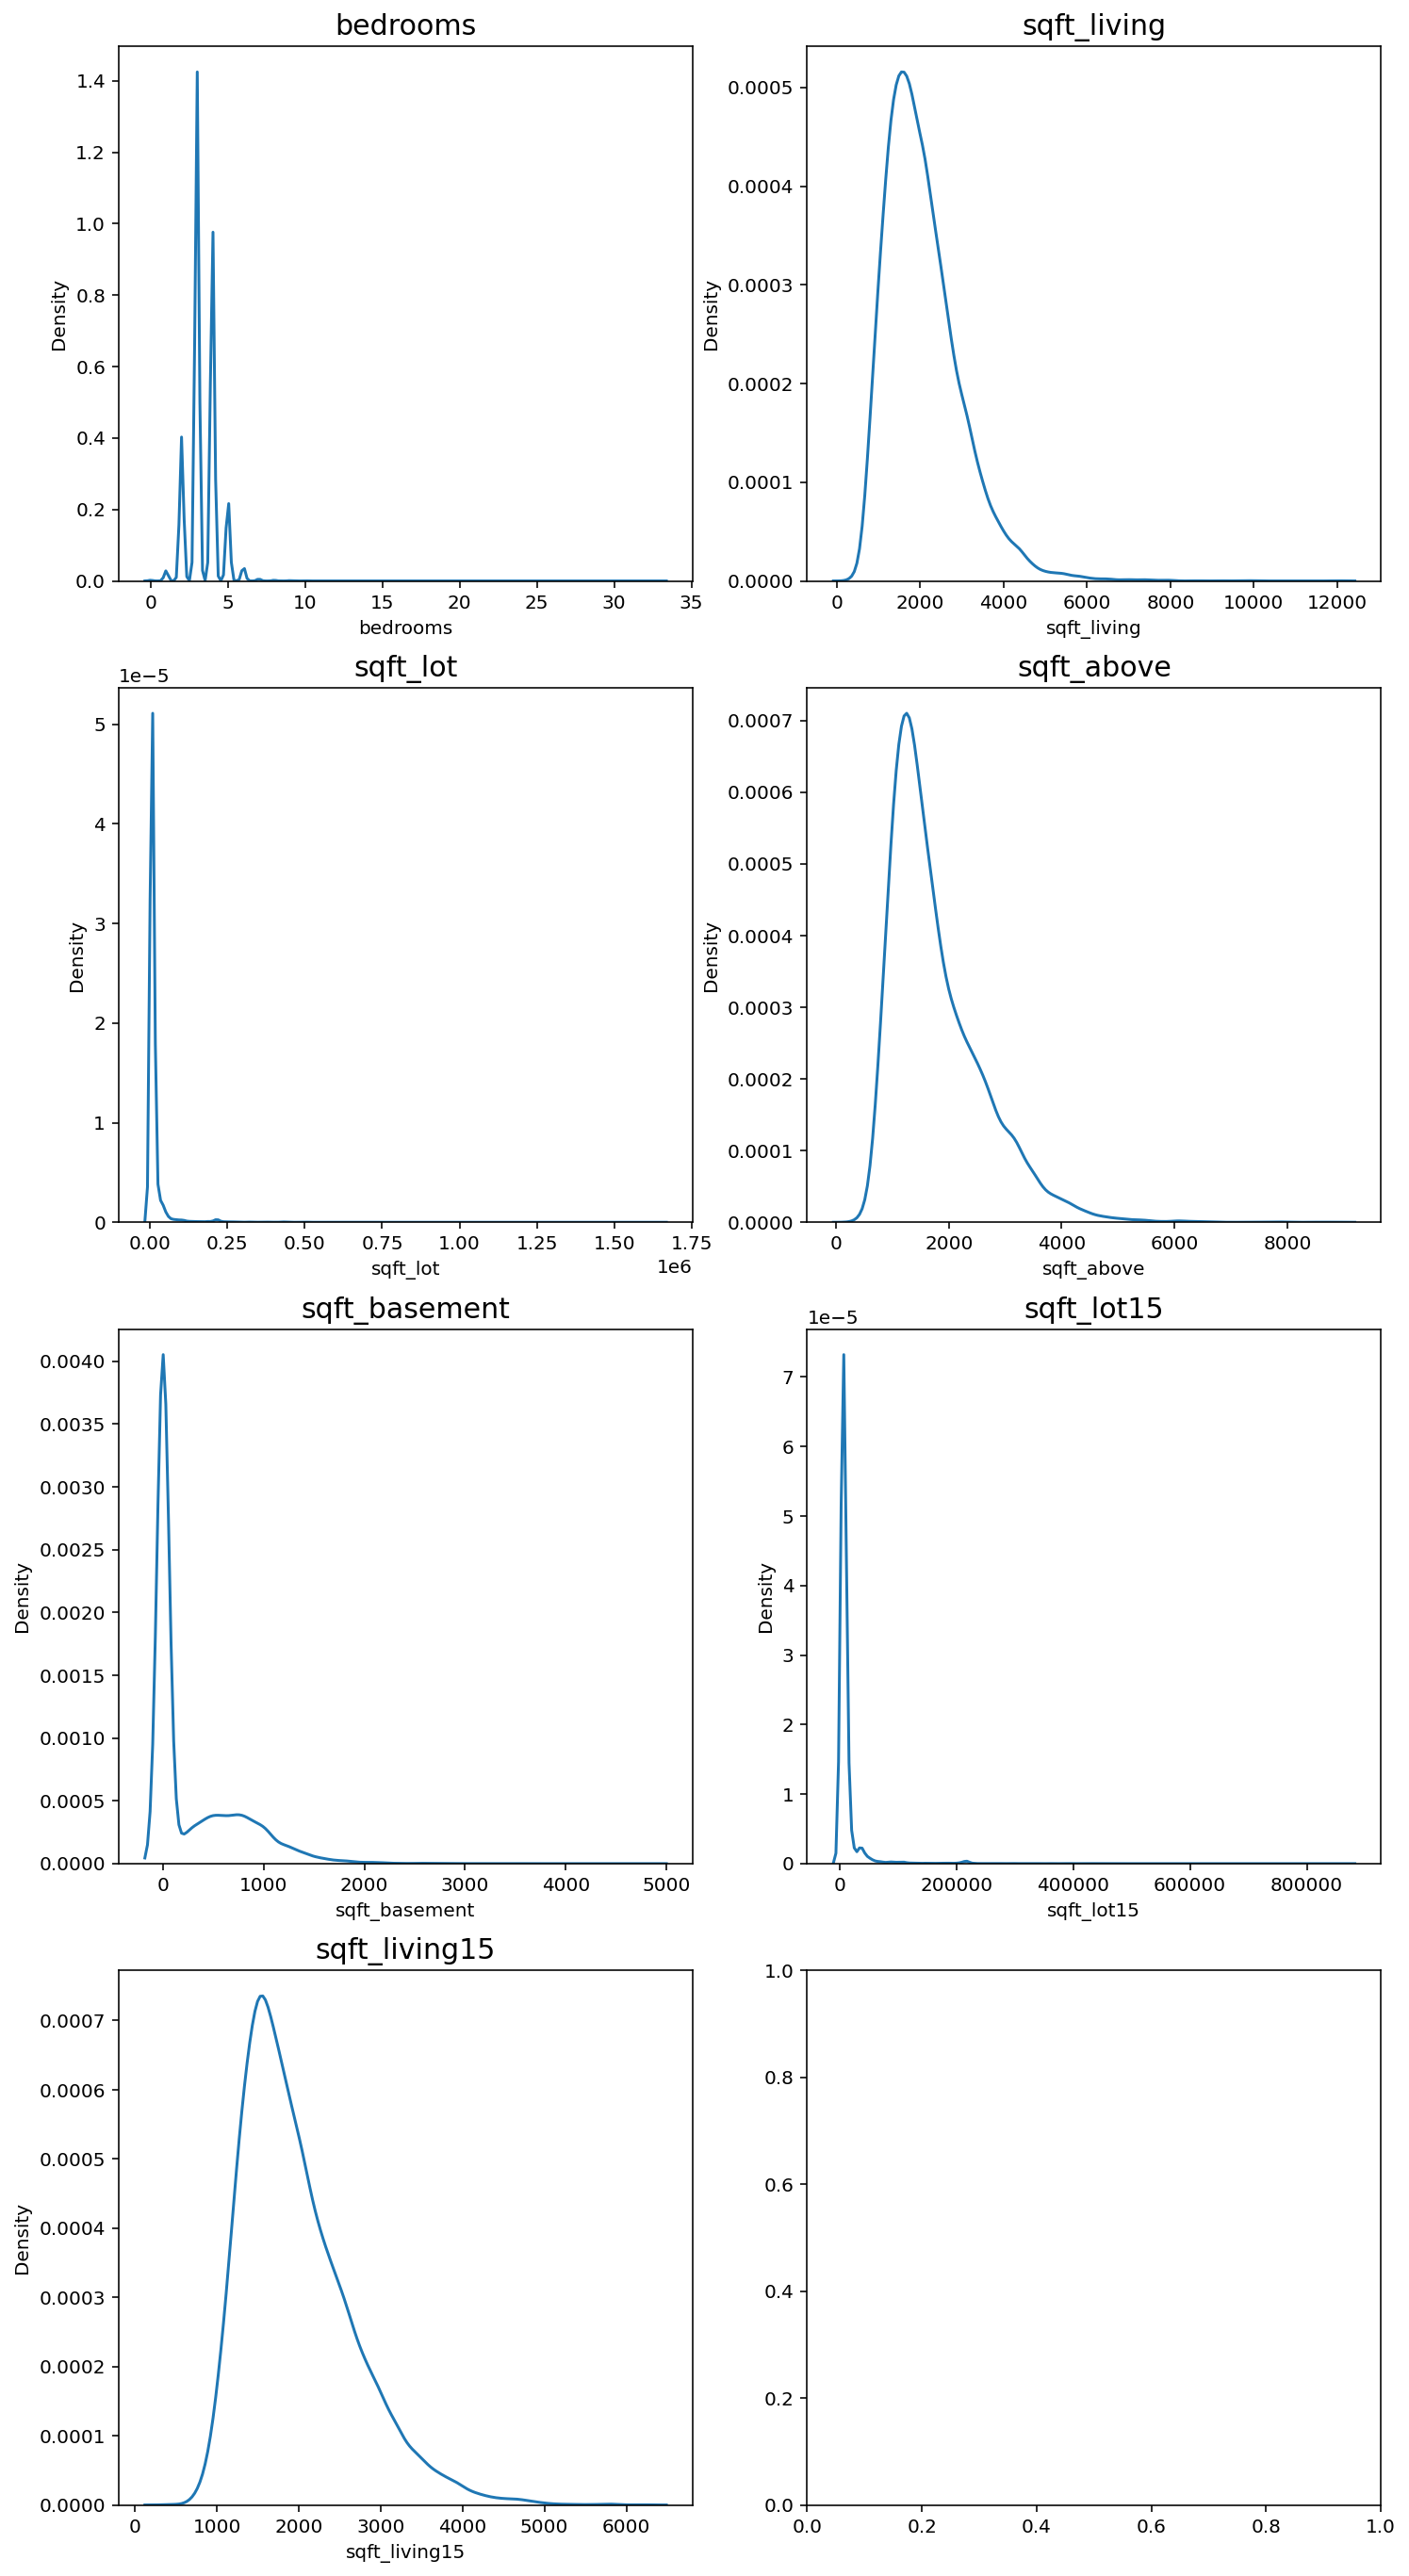

In [ ]:
## 그래프 전처리
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

#재확인
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=plus[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [ ]:
print(plus.shape)

(21501, 21)


In [ ]:
#데이터 나누기

#test = plus.iloc[train_len:, :]
#x = plus.iloc[:train_len, :]

test = plus.iloc[train_len:, :]
x = plus.iloc[:train_len, :]

print(x.shape)
print(test.shape)

(15035, 21)
(6466, 21)


In [ ]:
#데이터 나누기
dataTrain = data[pd.notnull(plus['price'])].sort_values()
dataTest = data[~pd.notnull(plus['price'])].sort_values()

ValueError: ignored

In [ ]:
test.drop('id', inplace = True, axis = 1)
x.drop('id', inplace = True, axis = 1)

In [ ]:
x.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
test.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2,15037,20140512T000000,NaN,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,NaN,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,NaN,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
5,15040,20140703T000000,NaN,5,2.50,2270,6300,2.0,0,0,3,8,2270,0,1995,0,98092,47.3266,-122.169,2240,7005
6,15041,20140624T000000,NaN,3,1.75,1520,6380,1.0,0,0,3,7,790,730,1948,0,98115,47.6950,-122.304,1520,6235


In [ ]:
len(test)

6466

In [ ]:
x.tail()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15032,20140521T000000,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,20150223T000000,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,20141015T000000,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357
0,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000


In [ ]:
len(x)

15035

In [ ]:
y = x['price']
del x['price']
del test['price']

print(x.columns)

KeyError: ignored

In [ ]:
x['date'] = x['date'].apply(lambda i: i[:8]).astype("int")
test['date'] = test['date'].apply(lambda i: i[:8]).astype("int")

x.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
x.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


###모델링

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢
얍💢
얍💢
얍💢


In [ ]:
test.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2,15037,20140512T000000,NaN,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,NaN,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,NaN,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
5,15040,20140703T000000,NaN,5,2.50,2270,6300,2.0,0,0,3,8,2270,0,1995,0,98092,47.3266,-122.169,2240,7005
6,15041,20140624T000000,NaN,3,1.75,1520,6380,1.0,0,0,3,7,790,730,1948,0,98115,47.6950,-122.304,1520,6235


In [ ]:
plus.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,NaN,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,NaN,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,NaN,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,NaN,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,NaN,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [ ]:
y.head()

0    12.309987
1    12.100718
2    13.142168
3    12.458779
4    12.583999
Name: price, dtype: float64

In [ ]:
y.tail()

15032    12.793862
15033    12.899222
15034    12.691584
0              NaN
1              NaN
Name: price, dtype: float64

In [ ]:
def get_scores(models, x, y):
    # 답안 작성
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, x, y)

ValueError: ignored



---


#🤔 **회고** 🤔

## <이번 프로젝트에서 **어려웠던 점**>
###**🤷‍♀️18시간 동안 열심히 이상치 제거했는데 제출하니 점수에 변동이 없었던 것............^-^🤷‍♀️**

(1) Colab에서의 Conda 사용법

(2) EDA를 하면서 난 수많은 오류들....ㅠ
- AttributeError: module 'nltk' has no attribute 'data'
pandas Profiling

- EDA 데이터 탐색하기 : Cleaning and organizing data 와 Collecting data sets 처리에 거의 80% 걸림

- 판다스 프로파일링을 위한 설치    
<명령어 뜯어보기>
pip install [설치]   
\-U [최신버전 Update?]   
pip install -U pandas_profiling   
import pandas as pd   
import pandas_profiling   
    
(3) 그놈의!!!!!!!! 오류!!!!!!!!!!!!!!!!!!!!!1
- 이상치 제거하면 오류 나고..   
- 제거해서 데이터셋 나누니 NaN 때문에 오류나고....
- 오류의 연속은 5일 동안 했지만 여전히 빠져나오지 못했다.....    

    
## <프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.>
(1) Cross Validation 과정에서의 오류   
 WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror. 라는 오류가 발생

(2) 파라미터와 하이퍼파라미터 
- 파라미터 : 모델 내부에서 결정되는 변수로 그 값은 데이터로부터 결정된다.
- 하이퍼파라미터 : 모델링할 때 사용자가 직접 세팅해주는 값을 뜻한다.   

(3) RMSE이란?
-  평균 제곱근 오차(Root Mean Square Error; RMSE)로 추정 값 또는 모델이 예측한 값과 실제 환경에서 관찰되는 값의 차이를 다룰 때 쓰는 측도이다.

(4) GridSearchCV와 Random Search
- 그리드 탐색 : 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색함. 따라서 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리   
정해둔 공간에서만 탐색하기 때문에 최적의 조합을 놓칠 수 있음
- 랜덤 탐색 : 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법   
 최적의 조합을 찾을 수 있는 가능성이 있으나 언제나 최적의 조합을 찾는 것은 아님
<img src="https://d3s0tskafalll9.cloudfront.net/media/images/E10-13.max-800x600.png" width="" height=""  title="px(픽셀) 크기 설정" alt="터미널"></img><br/>

(5) 파이썬 데이터 시각화   
- 시각화하는데 정말 다양한 그래프가 있다는 것을 알았다.
- 각 그래프들은 필요 정보에 따라 알맞은 모양이 있는데 이를 위해 좀 더 공부하는 것이 좋을 것 같다.

(6) Heatmap 데이터 시각화   
- Heatmap 시각화에는 2가지 방법이 있다.   
- 하나는 Matplotlib를 이용하는 것이고, 하나는 seaborn을 이용하는 것인데   
seaborn을 이용하는 것이 훨씬 간결하게 나타낼 수 있다.   
- 처음에는 Matplotlib를 사용하였는데 크기를 크게 조절해주어도 그래프가 뭉개지는 현상이 보였다.   
그래서 seaborn 으로 수정하였더니 훨씬 깔끔하고 수치도 눈에 잘 들어왔다.   
그래서 이번 캐글에서는 seaborn 으로 heatmap 시각화를 진행하였다.
- resize 하는 방법
  - seaborn : sns.set(rc = {'figure.figsize':(25,25)})
  - Matplotlib: plt.figure(figsize = (15,8))   

처음에 전체 데이터 시각화 할 때 resize 했다가 상위 10개만 추출하면서 resize가 필요없어 지움.

(7) 이상치란?
- 관측된 데이터의 범위에서 많이 벗어난 아주 작은 값이나 아주 큰 값을 말함
- 이상치 계산법은 따로 아래 링크로 걸어두겠다.

(8)내림차순, 오름차순 정렬하는 방법    
sort_values( ) 를 사용한다.    
- 오름차순 : ascending = True 또는 생략
- 내림차순 : ascending = False
    
.    
    
## <루브릭 평가 지표를 맞추기 위해 **시도한 것들**.>
(1) 우선 Price에 영향을 많이 주는 요소들을 찾고 싶었다.   
  처음부터 간단하게 하이퍼파라미터를 튜닝할 수 있겠었지만, LMS 5-13 상단에 나와 있는 **'예를 들면 가장 기본적으로는 데이터를 깊게 탐색하는 EDA 과정을 통해 불필요한 피처를 골라내거나 적절하게 피처를 수정하는 등의 피처 엔지니어링을 진행함으로써 데이터를 정제하는 것이 매우 중요합니다.'** 라는 문장을 보고 정석대로 한 번 시도해보고 싶었다. 

(2) EDA 수행을 위해 dataprap 설치 등을 시도하였으나 계속되는 시스템 충돌 오류로 인해 다른 방법을 찾아보았더니 heatmap으로 상관관계 파악하는 방법을 알게 되었다.   

(3) 히트맵을 통해 price에 영향을 주는 상위 5개 지표들을 찾아 그래프화한 후 일정 범위 이상을 넘어서는 값을들 지우고자 한다. 이를 이상치 측정 및 삭제라고 하더라.   
    
.    
    
##<만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.>
없음
    
.    
    
## <**자기 다짐**>
#👍교훈 : 실력이 없으면 객기 부리지 말자!👍
일단 주말 이틀 연속으로 새벽 5시까지 만지다보니....   
###하........괜한 짓을 한 것 같다...... 뭐하러....이상치를 제거한다고 한지 모르겠다...........ㅠㅠ   
ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...   
그래도 덕분에 뭔갈 많이 얻어간 것 같다...   
앞으론 욕심 부리지 말아야겠다...!   
내가 배운 범위 내에서 해결하도록 노력해야겠다.........

#Reference
1. https://towardsdatascience.com/conda-google-colab-75f7c867a522
2. https://velog.io/@sossont/EDA-%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%84%EC%84%9D%ED%95%98%EA%B8%B0Pandas
3. https://pypi.org/project/dataprep/
4. https://docs.python.org/3/tutorial/venv.html
5. https://docs.dataprep.ai/user_guide/eda/introduction.html
6. https://aimb.tistory.com/179 가상환경... 왜 해결이 안되죠?ㅠㅠ
7. 파이썬 데이터 시각화 : https://youngwonhan-family.tistory.com/62
8. 그래프 종류 : http://growthj.link/python-seaborn-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%8B%9C%EA%B0%81%ED%99%94-%EC%B4%9D%EC%A0%95%EB%A6%AC/
9. 이상치에 대해 : http://www.databaser.net/moniwiki/wiki.php/%EC%9D%B4%EC%83%81%EC%B9%98%EC%A0%9C%EA%B1%B0%EB%B0%A9%EB%B2%95
